In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from tqdm import tqdm
from scipy import stats
from scipy import signal
from scipy.spatial.distance import euclidean

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import matthews_corrcoef, classification_report, ConfusionMatrixDisplay,  confusion_matrix

In [2]:
ecg = np.loadtxt("ecg.csv", delimiter=",")

In [4]:
X, y = ecg[:,:-1], ecg[:, -1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [81]:
X_train.shape

(3998, 140)

## Mean, Standard Deviation and Slope

In [35]:
def get_subsequence(X, wsize=20):
    N = X.shape[1]
    sub_seq_X = np.zeros(shape=(X.shape[0], N//wsize, 3))
    xx = np.arange(wsize)
    
    for idx, i in tqdm(enumerate(range(0, N-wsize+1, wsize))):
        m = X[:, i:i+wsize].mean(axis=1).reshape(-1,1)
        s = X[:, i:i+wsize].std(axis=1).reshape(-1,1)
        a = np.array([
            np.polyfit(xx, ts[i:i+wsize], deg=1)[1] for ts in X
        ]).reshape(-1,1)

        sub_seq_X[:, idx] = np.concatenate((m,s,a), axis=1)
    return sub_seq_X

Generate subsequences of size *wsize* for each sample on the training set

In [79]:
wsize=10
subX = get_subsequence(X_train, wsize)
subTest = get_subsequence(X_test, wsize)

14it [00:03,  4.09it/s]
14it [00:00, 16.98it/s]


In [59]:
subX.shape

(3998, 14, 3)

Separate each subsequence to consider it as a standalone dataset

In [80]:
subX = [subX[:, i, :] for i in range(subX.shape[1])]
subTest = [subTest[:, i, :] for i in range(subTest.shape[1])]

Extract feature importances and test scores for each of the subsamples

In [89]:
results = pd.DataFrame(columns = ["Mean", "Std", "Slope", "Score"])
for i, sub in tqdm(enumerate(subX)):
    sub_train, sub_test, suby_train, suby_test= train_test_split(
        sub,
        y_train, 
        test_size=0.2
    )
    
    rf = RandomForestClassifier().fit(sub_train, suby_train)
    
    results.loc[i] = dict(
        zip(["Mean", "Std", "Slope"], rf.feature_importances_)
    ) | {"Score": rf.score(sub_test, suby_test)}

14it [00:05,  2.69it/s]


We can now have an overview of which **Subsequence** has the most relevant information, due to the score, and which of the **Features** is related to that score, due to the feature score of the *Random Forest Model*

In [91]:
results[results.Score>0.9]

,Mean,Std,Slope,Score
0,0.231393,0.504355,0.264253,0.95500
1,0.151083,0.500683,0.348234,0.93375
2,0.315788,0.363641,0.320570,0.93375
3,0.396301,0.191538,0.412161,0.91125
4,0.217517,0.463257,0.319226,0.94250
9,0.157501,0.395142,0.447357,0.92625
10,0.371394,0.346060,0.282546,0.97000
11,0.408893,0.362179,0.228928,0.95500
12,0.185711,0.161452,0.652837,0.97125
13,0.505915,0.187030,0.307055,0.95875


We can see that *subsequence $12$* seems to be the more promissing, having a **high score** with a **very high** feature importance in the **slope**

In [92]:
subX_train = subsequences[12][:,-1:]
subX_test = test_sub[12][:,-1:]

In [93]:
lr = LogisticRegression().fit(subX_train, y_train)
lr.score(subX_train, y_train)

0.9394697348674337

In [94]:
lr.score(subX_test, y_test)

0.927

In [183]:
preds = lr.predict(subX_test)

In [186]:
matthews_corrcoef(y_test, preds)

0.8489431654413917

In [185]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       408
         1.0       0.94      0.94      0.94       592

    accuracy                           0.93      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



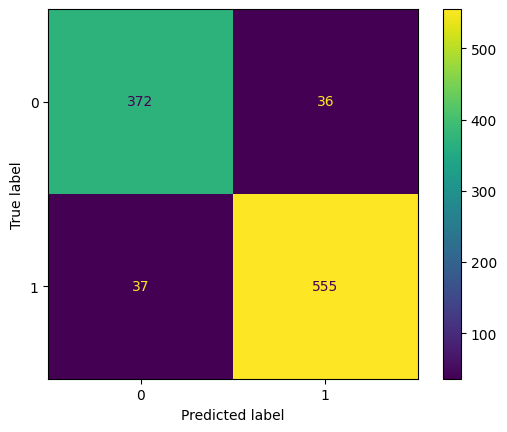

In [187]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

Good results with a small subsequence of the data, using a single, and easy to calculate, feature. This with a transparent model, with high explainability.

Other method would be to fit a decision tree for each of the subsequences, and have a majority vote

In [174]:
class DummyRF:
    def __init__(self):
        self.trees = []
    
    def predict(self, subsequences):
        subsequences = np.array(subsequences)
        votes = []
        
        for i, sub in tqdm(enumerate(subsequences)):
            votes.append(
                self.trees[i].predict(sub).reshape(-1,1)
            )
        
        votes = np.concatenate(votes, axis=1)
        votes = list(map(lambda x: np.unique(x, return_counts=True), votes))
        votes = list(map(lambda x: x[0][np.argmax(x[1])], votes))
        return np.array(votes).astype(int)

    def fit(self, subsequences, y):
        self.trees=[]
        for sub in subsequences:
            dt = DecisionTreeClassifier().fit(sub, y)
            self.trees.append(dt)
        return self
    
    def score(self, subsequences, y):
        acc = 0
        for i, sub in tqdm(enumerate(subsequences)):
            acc+=self.trees[i].score(sub, y)
        return acc/len(self.trees)

In [175]:
rf = DummyRF().fit(subX, y_train)

In [176]:
rf.score(subX, y_train)

14it [00:00, 789.61it/s]


1.0

In [177]:
rf.score(subTest, y_test)

14it [00:00, 895.99it/s]


0.8655

In [188]:
preds = rf.predict(subTest)

14it [00:00, 6902.58it/s]


In [189]:
print(matthews_corrcoef(y_test, preds))

0.946226862846162


In [190]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       408
         1.0       0.98      0.98      0.98       592

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



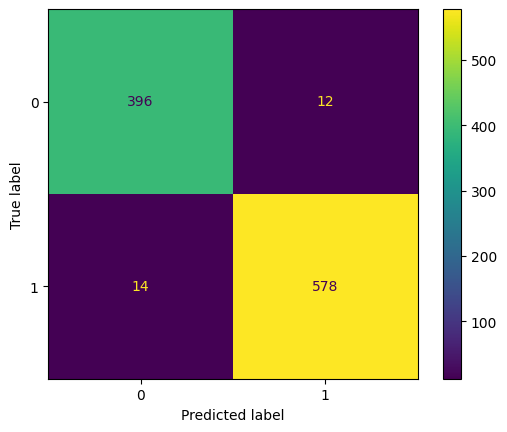

In [191]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

Even better results using an Ensemble model with every subsequence. Still using a transparent model for each interval has a high interpretability.